In [1]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from utils.basic_utils import csv_store, csv_ext, numeric_cols
from utils.pricing import dummy_col, px_fwd_ret, get_ind_index, discret_rets
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

Loading utils/config.json


Using TensorFlow backend.


In [14]:
pd.options.display.float_format = '{:,.3f}'.format
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = [5.0, 3.0]
mpl.rcParams['font.size'] = 8
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context data

In [46]:
# context
context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'px_vol_ds': 'universe-px-vol-ds.h5',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*3,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 300, #850
    'max_iter': 10, #50
    'l2_reg': 0.01,
}

In [ ]:
# get latest pricing file from inferece instance

In [64]:
px_close_ds = context['px_vol_ds']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-vol-ds.h5                         100%  228MB   9.8MB/s   00:23    


In [62]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
    max_draw_on=True, 
    tickers='All',
#   tickers=None, quantile=0.75
)
y_col = tech_ds.ycol_name

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4673 entries, 2004-05-26 to 2019-05-27
Columns: 6380 entries, (high, 0700.HK) to (volume, ^VIX)
dtypes: float32(6380)
memory usage: 113.8 MB
None
Target date: 2019-05-28
Loading file quote/csv/2019-05-28
Loading file summary-categories/assetProfile
1199 companies
Universe sectors: 11, industries: 136


In [63]:
tech_ds.clean_px['AAPL'].tail()

storeDate
2019-05-20   183.090
2019-05-21   186.600
2019-05-22   182.780
2019-05-23   179.660
2019-05-24   178.970
Name: AAPL, dtype: float32

### Predict

In [47]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [48]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

In [49]:
%%time 
# predict for all
pred_df = predict_ds(context)

OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Max draw/pull dataframes
Ranked returns dataframes
Forward return dataframe
Group index
Group percentage changes
Group pct stds
Group performance deltas
% above MA by group
% positive / negative chg stds by group
Group 50 day stds
Group 50 day deltas
Ranked returns dataframes
Dataset columns: Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'MaxDraw120',
       'MaxPull120', 'PerfRank20', 'PerfRank50', 'PerfRank200', 'fwdRet120',
       '50StdsAll', '50StdsSect', '50StdsInd', '200StdsAll', '200StdsSect',
       '200StdsInd', 'pctGt50MAAll', 'pctGt50MASect', 'pctGt

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


pred_X.shape (895860, 70)
pred_X.shape (895860, 69)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-27.csv
CPU times: user 22min 50s, sys: 29min 46s, total: 52min 37s
Wall time: 9min 55s


In [25]:
# pred_df.reset_index().to_feather(tmp_path + 'micro_pred.feat')
pred_df.to_hdf(tmp_path + 'micro_pred.h5', key='micro_pred')

In [16]:
# pred_df = pd.read_feather(tmp_path + 'micro_pred.feat')
# pred_df = pred_df.set_index('pred_date')
pred_df = pd.read_hdf(tmp_path + 'micro_pred.h5')

In [17]:
pred_df.head()

symbol  pred_class pred_label  confidence  bear  short  neutral  \
pred_date                                                                      
2009-05-19  0700.HK           0       bear         nan   nan    nan      nan   
2009-05-19  1810.HK           0       bear         nan   nan    nan      nan   
2009-05-19  3690.HK           0       bear         nan   nan    nan      nan   
2009-05-19        A           4       bull       1.000 0.000  0.000    0.000   
2009-05-19      AAL           0       bear       0.464 0.464  0.158    0.136   

            long  bull  
pred_date               
2009-05-19   nan   nan  
2009-05-19   nan   nan  
2009-05-19   nan   nan  
2009-05-19 0.000 1.000  
2009-05-19 0.015 0.226

In [56]:
# read from S3
from utils.basic_utils import csv_load
s3_path = context['s3_path']
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tech_ds.tgt_date}'), 
    index_col='pred_date', parse_dates=True)

In [60]:
pred_df.tail()

symbol  pred_class pred_label  confidence  bear  short  neutral  \
pred_date                                                                    
2019-05-24    ZEN           4       bull       0.954 0.017  0.000    0.001   
2019-05-24   ZION           4       bull       0.965 0.008  0.002    0.011   
2019-05-24    ZTO           4       bull       0.476 0.434  0.028    0.036   
2019-05-24    ZTS           4       bull       0.660 0.013  0.021    0.185   
2019-05-24    ZUO           0       bear       0.458 0.458  0.076    0.197   

            long  bull  
pred_date               
2019-05-24 0.028 0.954  
2019-05-24 0.014 0.965  
2019-05-24 0.027 0.476  
2019-05-24 0.121 0.660  
2019-05-24 0.070 0.200

#### Visualize one company

In [18]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


bear      0.501
bull      0.322
neutral   0.147
long      0.016
short     0.014
Name: pred_label, dtype: float64

In [24]:
symbol = np.random.choice(tech_ds.tickers)
# symbol = 'EXEL'
clean_px, labels = tech_ds.clean_px, tech_ds.forward_return_labels
print(f'Active symbol: {symbol}\n first five elements: {tech_ds.tickers[:5]}')

Active symbol: MRK
 first five elements: ['0700.HK', '1810.HK', '3690.HK', '9984.T', 'A']


In [25]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df, labels):
    
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_df.pct_change(look_ahead)
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)
    
    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
#         figsize=(10, 2), 
        grid=True,
        rot=0,
        ax=axes[0])

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
#         figsize=(10, 3), 
        secondary_y='pred_class',
        rot=0,
        ax=axes[1])

    # probability distribution
    co_pred[labels].plot.area(
        title=f'{pred_symbol} Prediction probabilities', 
#         figsize=(10, 2), 
        ylim=(0, 1), 
        cmap='RdYlGn', 
        rot=0,
        ax=axes[2])

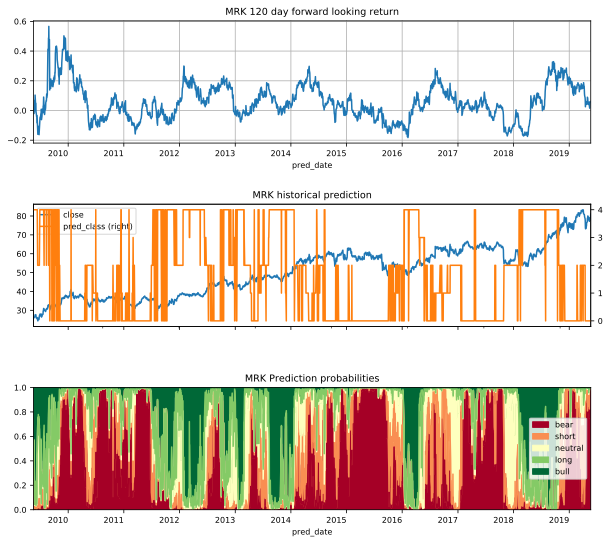

In [26]:
plot_symbol_hist_pred(symbol, clean_px, context, pred_df, labels)

In [27]:
pred_df.loc[pred_df.symbol.isin([symbol])].head()

symbol  pred_class pred_label  confidence  bear  short  neutral  \
pred_date                                                                    
2009-05-19    MRK           4       bull       0.876 0.060  0.010    0.045   
2009-05-20    MRK           4       bull       0.708 0.076  0.022    0.175   
2009-05-21    MRK           4       bull       0.426 0.325  0.076    0.166   
2009-05-22    MRK           4       bull       0.456 0.286  0.058    0.192   
2009-05-26    MRK           4       bull       0.957 0.007  0.003    0.027   

            long  bull  
pred_date               
2009-05-19 0.010 0.876  
2009-05-20 0.019 0.708  
2009-05-21 0.008 0.426  
2009-05-22 0.007 0.456  
2009-05-26 0.006 0.957

### AI driven portfolio construction

In [57]:
long = True # enable long or short
loss_protection = False # stop losses dont seem to help
max_loss = 0.1
holding_period = 120 # how many days to hold / rebalance
as_of_date = -1; study_period = -10;
watch_overtime = True # pick same days prediction of most frequent over study period
min_confidence = 0.95; period_tresh = 0.5
nbr_positions = 10
pred_classes = [3, 4] if long else [0, 1]
look_ahead, look_back = context['look_ahead'], context['look_back']

#### One period

In [58]:
def get_top_predictions(pred_df, as_of_date, min_confidence):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])) \
        & (pred_df.confidence > min_confidence)

    idx = pred_df.index.unique()[as_of_date]
    top_pred = pred_df.loc[(pred_df.index == idx) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence)
top_pred.loc[top_pred.pred_class.isin(pred_classes)].head(nbr_positions)

symbol  pred_class pred_label  confidence  bear  short  neutral  \
pred_date                                                                    
2019-05-24    AYX           4       bull       1.000 0.000  0.000    0.000   
2019-05-24   OLED           4       bull       1.000 0.000  0.000    0.000   
2019-05-24   RAMP           4       bull       1.000 0.000  0.000    0.000   
2019-05-24   CCOI           4       bull       0.999 0.000  0.000    0.000   
2019-05-24   MIME           4       bull       0.999 0.000  0.000    0.000   
2019-05-24   NGVT           4       bull       0.999 0.000  0.000    0.000   
2019-05-24   SHOP           4       bull       0.999 0.000  0.000    0.000   
2019-05-24   CHTR           4       bull       0.997 0.000  0.000    0.001   
2019-05-24    IQV           4       bull       0.997 0.001  0.001    0.001   
2019-05-24     SQ           4       bull       0.997 0.001  0.000    0.001   

            long  bull  
pred_date               
2019-05-24 0.000 1.000  
2019-05-24 0.000 1.000  
2019-05-24 0.000 1.000  
2019-05-24 0.001 0.999  
2019-05-24 0.001 0.999  
2019-05-24 0.000 0.999  
2019-05-24 0.001 0.999  
2019-05-24 0.002 0.997  
2019-05-24 0.001 0.997  
2019-05-24 0.001 0.997

In [52]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    return pred_df.index.unique()[study_period + as_of_date:as_of_date]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)

In [41]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, treshold=0.6):
    """ return most frequent predictions of a given class for a study period """
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']].reset_index()
    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class']).agg(['count', 'mean']).reset_index()
    result = most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * treshold))]\
        .sort_values(by=[('confidence', 'count'), ('confidence', 'mean')], ascending=False)
    
    return result

if watch_overtime:    
    most_freq_df = get_most_frequent_preds(
        pred_df, study_dates, top_pred, pred_classes, period_tresh)
    top_pos = most_freq_df.head(nbr_positions)
else:
    top_pos = top_pred.loc[
        top_pred.pred_class.isin(pred_classes) & 
        top_pred.confidence > min_confidence].head(nbr_positions)

symbols = list(top_pos.symbol)

In [42]:
get_most_frequent_preds(
        pred_df, study_dates, top_pred, pred_classes, period_tresh).head(nbr_positions)

symbol pred_class confidence      
                           count  mean
165   RAMP          4         10 1.000
77    FIVE          4         10 1.000
35    CCOI          4         10 0.999
47    COST          4         10 0.995
209    TTD          4         10 0.994
40    CHTR          4         10 0.993
144    NUS          4         10 0.993
141   NSTG          4         10 0.992
121   MNRO          4         10 0.985
203    TKC          4         10 0.985

In [916]:
print(f'{len(symbols)} Symbols: {symbols}')

10 Symbols: ['MIME', 'NEWR', 'CYBR', 'FIVN', 'CHTR', 'UBNT', 'MDSO', 'GWRE', 'AU', 'GDS']


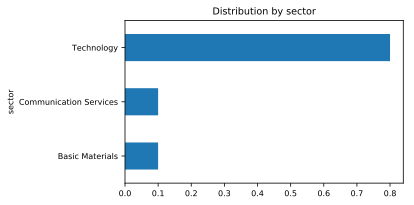

In [919]:
# Distribution by sector
by_sect = tech_ds.profile.loc[symbols].groupby(by=['sector'])\
    .count().iloc[:,0].sort_values()
(by_sect / by_sect.sum()).plot.barh(title='Distribution by sector');

In [920]:
# Distribution by industry
by_ind = tech_ds.profile.loc[symbols].groupby(by=['sector', 'industry'])\
    .count().iloc[:,0]
by_ind

sector                  industry                   
Basic Materials         Gold                           1
Communication Services  Pay TV                         1
Technology              Communication Equipment        1
                        Data Storage                   1
                        Health Information Services    1
                        Software - Infrastructure      5
Name: address1, dtype: int64

In [921]:
# Most consistent predictions
if watch_overtime:
    port_selection = top_pos.sort_values(
        by=[('confidence', 'count'), ('confidence', 'mean')], 
        ascending=False)
else: port_selection = top_pos

Showing returns from DatetimeIndex(['2018-11-27', '2019-05-21'], dtype='datetime64[ns]', name='storeDate', freq=None)
Portfolio shape: (120, 11)


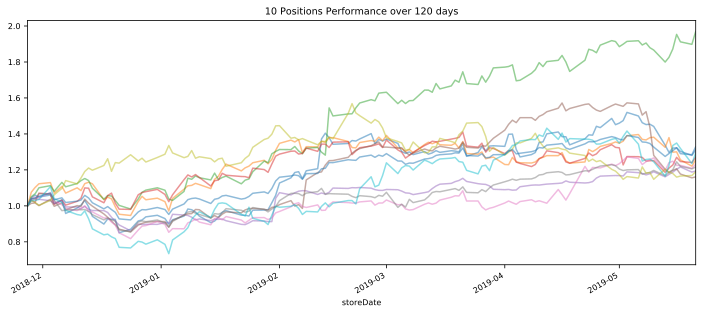

In [922]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    pos = truth_df[truth_df == True]
    if len(pos): df.loc[pos.index[0]:] = df.loc[pos.index[0]]
    return df

idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {tech_ds.clean_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')
port_index.plot(
    title=f'{nbr_positions} Positions Performance over {holding_period} days', 
    figsize=(12,5),
    alpha=0.5,
    legend=False);

Hit Rate: 100.0%


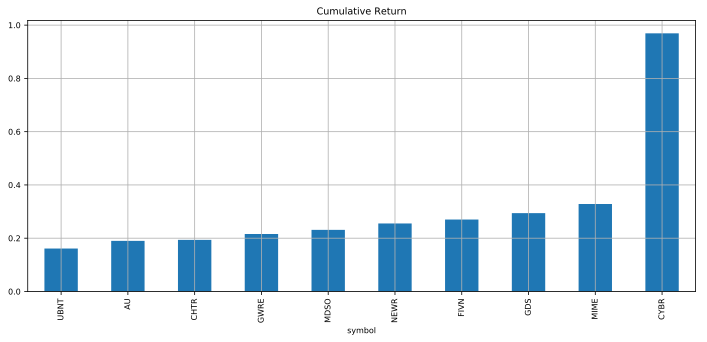

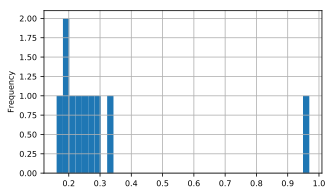

In [923]:
net_return = (port_index.iloc[-1, :-1] - 1)
hit_mask = net_return>0 if long else net_return<0
hit_rate = net_return.where(hit_mask).count() / net_return.count()
print(f'Hit Rate: {round(hit_rate*100, 1)}%')
net_return.sort_values().plot.bar(title='Cumulative Return', grid=True, figsize=(12,5)); plt.show()
net_return.plot.hist(bins=40, grid=True);

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


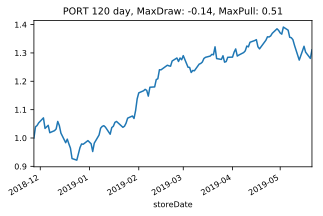

In [924]:
# cumulative returns for a given portfolio
max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)

port_index.iloc[:, -1].plot(
    title=f'PORT {holding_period} day, MaxDraw: {max_d}, MaxPull: {max_p}');

In [925]:
# cumulative returns for a given portfolio
port_index.iloc[-1, :-1].describe()

count   10.00
mean     1.31
std      0.24
min      1.16
25%      1.20
50%      1.24
75%      1.29
max      1.97
Name: 2019-05-21 00:00:00, dtype: float64

In [926]:
print(port_index.shape)
port_index.tail()

(120, 11)


symbol      MIME  NEWR  CYBR  FIVN  CHTR  UBNT  MDSO  GWRE   AU  GDS  PORT
storeDate                                                                 
2019-05-15  1.32  1.30  1.87  1.23  1.19  1.20  1.25  1.20 1.18 1.34  1.31
2019-05-16  1.32  1.30  1.95  1.27  1.20  1.21  1.23  1.24 1.16 1.35  1.32
2019-05-17  1.29  1.26  1.91  1.25  1.22  1.18  1.23  1.22 1.17 1.32  1.30
2019-05-20  1.28  1.22  1.90  1.24  1.19  1.16  1.21  1.21 1.17 1.24  1.28
2019-05-21  1.33  1.26  1.97  1.27  1.19  1.16  1.23  1.22 1.19 1.29  1.31

### Backtesting multiple experiments

In [970]:
# for both long and short do not refresh indices, to capture same periods
nbr_experiments = 300
describe_list = []; symbol_list = []; port_beg = []; port_end = []
profile, quotes = tech_ds.profile, tech_ds.quotes

pred_period_range = range(-study_period, pred_df.index.unique().shape[0] - holding_period)
start = np.random.choice(pred_period_range, size=1)
asofs_idx = np.unique([x for x in np.random.choice(pred_period_range, size=nbr_experiments)]) #random
# asofs_idx = [x for x in pred_period_range[:nbr_experiments]] # sequential
print(f'Selected dates {len(asofs_idx)}')
pred_df.index.unique()[asofs_idx]

Selected dates 283


DatetimeIndex(['2009-06-04', '2009-06-08', '2009-06-18', '2009-07-02',
               '2009-07-09', '2009-07-17', '2009-07-23', '2009-08-07',
               '2009-08-10', '2009-08-17',
               ...
               '2018-08-20', '2018-08-27', '2018-08-28', '2018-09-10',
               '2018-09-14', '2018-10-01', '2018-10-25', '2018-10-31',
               '2018-11-07', '2018-11-19'],
              dtype='datetime64[ns]', name='pred_date', length=283, freq=None)

In [971]:
%%time
# What are the best portfolios and how do they perform?
for as_of_date in asofs_idx:

    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence)

    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    idx = tech_ds.clean_px.index.get_loc(study_dates[-1])

    if watch_overtime:    
        most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, period_tresh)
        top_pos = most_freq_df.head(nbr_positions)
    else:
        top_pos = top_pred.loc[top_pred.pred_class.isin(pred_classes) & top_pred.confidence > min_confidence].head(nbr_positions)    
    
    symbols = list(top_pos.symbol)
    
    if len(symbols) > 5:

        prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        net_return = (port_index.iloc[-1, :-1] - 1)
        hit_mask = net_return>0 if long else net_return<0
        hit_rate = net_return.where(hit_mask).count() / net_return.count()
        
        pos_beg = port_index.iloc[0, :-1]
        pos_end = port_index.iloc[-1, :-1]
        max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
        max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)
        
        exp_describe = pos_end.describe()
        exp_describe['hit_rate'] = hit_rate
        exp_describe['max_draw'] = max_d
        exp_describe['max_pull'] = max_p
        exp_describe['offset_start'] = as_of_date
        exp_describe['as_of_date'] = str(study_dates[-1])
        exp_describe['study_period'] = study_period
        exp_describe['end_date'] = str(port_index.index[-1])
        port_beg.append(pos_beg)
        port_end.append(pos_end)
        symbol_list.append(symbols)
        describe_list.append(exp_describe)

portfolio_sel = pd.concat(port_beg, axis=1, sort=False).T
position_perf = pd.concat(port_end, axis=1, sort=False).T
hist_ports = pd.concat(describe_list, axis=1, sort=False).T
hist_ports = hist_ports.infer_objects()

CPU times: user 2min 17s, sys: 2.3 s, total: 2min 19s
Wall time: 2min 19s


In [972]:
print(f'Summary for {len(asofs_idx)} unique {"LONG" if long else "SHORT"} experiments')
print(f'{len(position_perf.columns.unique())} unique symbols (from different portfolios)')

Summary for 283 unique SHORT experiments
765 unique symbols (from different portfolios)


In [973]:
grand_summary = hist_ports.describe().loc['mean']
cagr = round(grand_summary['mean'] ** (1/(holding_period/252)) - 1, 2)
print(f'CAGR: {cagr}')
grand_summary

CAGR: -0.31


count             19.99
mean               0.84
std                0.12
min                0.57
25%                0.78
50%                0.86
75%                0.92
max                1.01
hit_rate           0.94
max_draw          -0.22
max_pull           0.10
offset_start   1,170.77
study_period     -10.00
Name: mean, dtype: float64

#### Descriptive stats

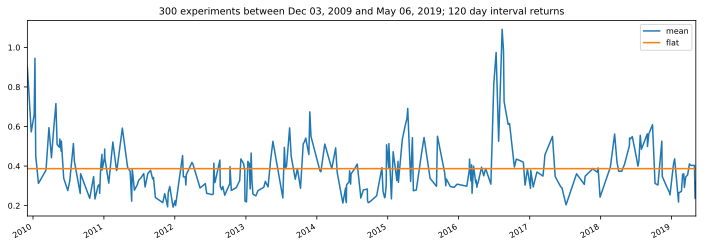

In [818]:
import datetime
monthly_rets = (hist_ports['mean']-1).to_frame()

from_dt = monthly_rets.index[0].strftime('%b %d, %Y')
to_dt = monthly_rets.index[-1].strftime('%b %d, %Y')
monthly_rets['flat'] = monthly_rets['mean'].mean()
ax = monthly_rets.plot(
    title=f'{nbr_experiments} experiments between {from_dt} and {to_dt}; {holding_period} day interval returns', 
    figsize=(12,4))
# x_labels = monthly_rets.index.strftime('%b %y')
# ax.set_xticklabels('');

In [819]:
perf_col = f'perfAttrib{holding_period}D'
pos_attribution = position_perf.mean()
uniq_pos_perf = pos_attribution.to_frame()
uniq_pos_perf.columns = [perf_col]
uniq_pos_perf['name'] = quotes.loc[uniq_pos_perf.index, ['shortName']]
uniq_pos_perf[['sector', 'industry']] = profile.loc[uniq_pos_perf.index, ['sector', 'industry']]

In [820]:
# top ten attribution
top10_attrib = uniq_pos_perf.sort_values(by=perf_col, ascending=False).head()
top10_attrib

perfAttrib120D                             name             sector  \
BLUE            2.75               bluebird bio, Inc.         Healthcare   
AJRD            2.33  Aerojet Rocketdyne Holdings, In        Industrials   
DAN             2.19                Dana Incorporated  Consumer Cyclical   
IOVA            2.17    Iovance Biotherapeutics, Inc.         Healthcare   
EBR             2.14  Centrais Electricas Brasileiras          Utilities   

                            industry  
BLUE                   Biotechnology  
AJRD             Aerospace & Defense  
DAN                       Auto Parts  
IOVA                   Biotechnology  
EBR   Utilities - Regulated Electric

In [821]:
# bottom ten attribution
uniq_pos_perf.sort_values(by=perf_col, ascending=False).tail()

perfAttrib120D                          name             sector  \
CMC             1.09     Commercial Metals Company    Basic Materials   
TRIP            1.09             TripAdvisor, Inc.  Consumer Cyclical   
OI              1.07          Owens-Illinois, Inc.  Consumer Cyclical   
PLCE            1.07  Children's Place, Inc. (The)  Consumer Cyclical   
TSCO            1.06        Tractor Supply Company  Consumer Cyclical   

                    industry  
CMC                    Steel  
TRIP                 Leisure  
OI    Packaging & Containers  
PLCE          Apparel Stores  
TSCO        Specialty Retail

In [822]:
perf_sector = uniq_pos_perf.groupby(by=['sector']).agg(['mean', 'count'])
perf_ind = uniq_pos_perf.groupby(by=['industry']).mean().sort_values(by=perf_col) - 1

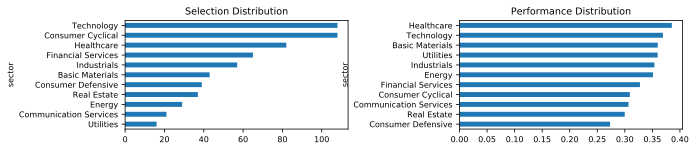

In [823]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
perf_sector[(perf_col, 'count')].sort_values().plot.barh(title='Selection Distribution', ax=axes[0]);
(perf_sector[(perf_col, 'mean')].sort_values() - 1).plot.barh(title='Performance Distribution', ax=axes[1]);

In [824]:
# Distribution by industry
by_ind = uniq_pos_perf.groupby(by=['sector', 'industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(20)

sector                  industry                      
Technology              Software - Application            25
Financial Services      Banks - Regional - US             20
Healthcare              Biotechnology                     19
Communication Services  Telecom Services                  18
Consumer Cyclical       Specialty Retail                  16
Healthcare              Diagnostics & Research            15
Energy                  Oil & Gas E&P                     15
Technology              Semiconductors                    15
Consumer Defensive      Packaged Foods                    12
Technology              Software - Infrastructure         12
Industrials             Business Services                 11
Real Estate             REIT - Diversified                11
Healthcare              Medical Instruments & Supplies    10
Basic Materials         Specialty Chemicals               10
Consumer Cyclical       Restaurants                       10
Industrials             Airlin

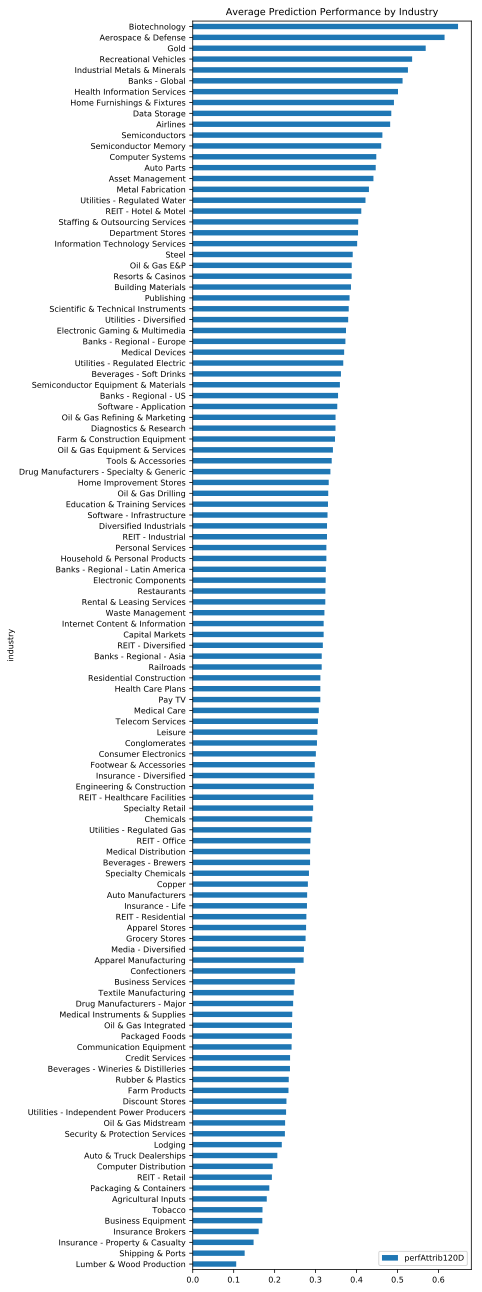

In [825]:
fsize = (5, len(perf_ind.index) / 25 * 5)
perf_ind.plot.barh(title='Average Prediction Performance by Industry', figsize=fsize);

In [826]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

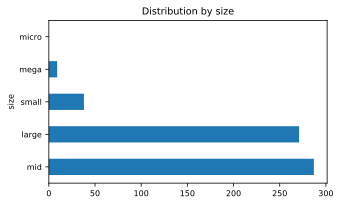

In [827]:
unique_symbols = list(uniq_pos_perf.index.unique())
size_df = tech_ds.quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

#### Most frequent

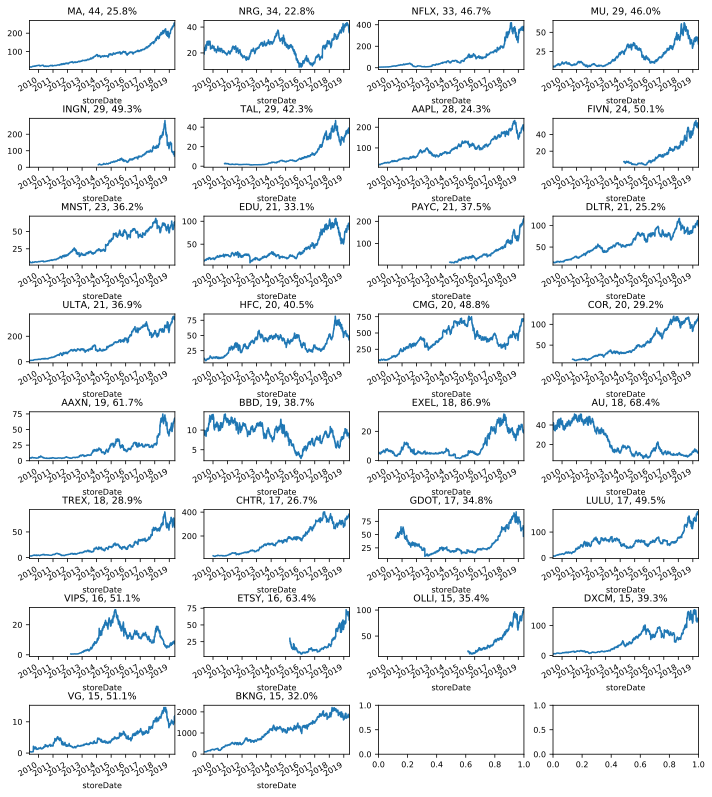

In [932]:
# Most common recommendations with realized performance
most_frequent = position_perf.count(axis=0).sort_values(ascending=False).head(30)
plot_df = most_frequent

lens = len(plot_df.index); cols = 4; rows = lens // cols + 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 15))
plt.subplots_adjust(hspace=1)

for i, t in enumerate(zip(most_frequent.index, most_frequent.values)):
    row = i // cols; col = i - cols * row
    avg_return = round((pos_attribution[t[0]]-1) * 100, 1)
    clean_px[t[0]].tail(look_back).plot(
        title=f'{t[0]}, {t[1]}, {avg_return}%',
        ax=axes[row, col])

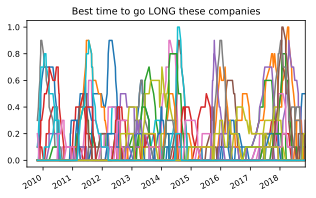

In [877]:
# how often are companies in the predictions?
df = portfolio_sel.sort_index().where(~portfolio_sel.isna(), 0)
# percentage of the time within a 30 day period that a company is recommended
likely_df = (df.rolling(-study_period).sum() / -study_period)

title = f'Best time to go {"LONG" if long else "SHORT"} these companies'
# symbols = ['NFLX', 'CRM', 'BLUE', 'TSLA']
# symbols = np.random.choice(likely_df.columns, size=10)
symbols = list(most_frequent.index)
likely_df[symbols].plot(title=title, legend=False); # mix of predictions is different everyday

# most_freq = likely_df.mean().sort_values().tail(10).index # most frequent
# df[symbols].plot.area();

count  mean   std   min   25%   50%   75%   max
count  30.00 30.00 30.00 30.00 30.00 30.00 30.00 30.00
mean   69.60  0.29  0.20  0.10  0.12  0.22  0.41  0.74
std    21.48  0.08  0.07  0.00  0.05  0.08  0.14  0.21
min    35.00  0.15  0.06  0.10  0.10  0.10  0.20  0.30
25%    53.00  0.24  0.16  0.10  0.10  0.20  0.30  0.70
50%    73.00  0.30  0.20  0.10  0.10  0.20  0.40  0.80
75%    81.50  0.34  0.24  0.10  0.10  0.30  0.50  0.90
max   133.00  0.45  0.31  0.10  0.30  0.40  0.70  1.00

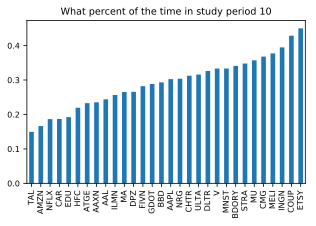

In [880]:
pct_study_period = likely_df[symbols].apply(lambda x: x.where(x>0))
pct_study_period.mean().sort_values().plot.bar(
    title=f'What percent of the time in study period {-study_period}');
pct_study_period.describe().T.describe()

#### Portfolio metrics

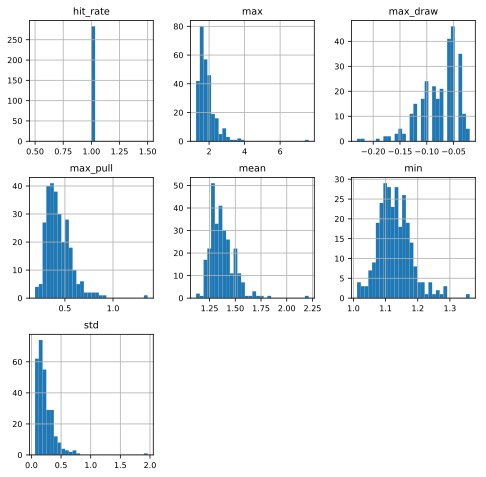

In [761]:
# relationship among position count, returns and risk
from pandas.plotting import scatter_matrix
show_cols = ['mean', 'std', 'min', 'max', 'hit_rate', 'max_draw', 'max_pull']
# scatter_matrix(
#     hist_ports[show_cols], 
#     figsize=(10,10));

hist_ports[show_cols].hist(bins=30, figsize=(8,8));
# hist_ports[show_cols].boxplot()

In [ ]:
##### full detail for all experiments
hist_ports.sort_values(by='mean')

#### Accuracy of predictions

In [624]:
cut_range = tech_ds.return_intervals()
pred_class_tresh = [cut_range[1], cut_range[2], 0, cut_range[3], cut_range[4]]
actual_gt_tresh = lambda x, y: x > y if x > 0 else x < y
right_direction = lambda x, y: x > 0 if x > 0 else x < 0

def hist_company_accuracy(symbol, pred_df, min_confidence, clean_px, pred_class_tresh, fn):
    co_pred = pred_df.loc[(pred_df.symbol.isin([symbol]) & pred_df.confidence > min_confidence), :]
    if len(co_pred) > 0 and t in clean_px.columns:
        fwd_return = clean_px[symbol].pct_change(look_ahead).shift(-look_ahead).loc[co_pred.index]
        if len(fwd_return.dropna()) > 0:
            pred_comparison = pd.concat([fwd_return, co_pred.pred_class.apply(lambda x: pred_class_tresh[x])], axis=1).dropna()
            count = pd.value_counts(pred_comparison.apply(lambda x: fn(x[0], x[1]), axis=1))
            return symbol, (count[True] / count.sum() if True in count else 0)

Treshold distributions: [ -inf -0.19 -0.1   0.13  0.24   inf]


In [627]:
symbol = 'ADBE'
hist_company_accuracy(symbol, pred_df, 0.90, clean_px, cut_range, right_direction)

('ADBE', 1.0)

In [ ]:
%%time
super_list = []
for t in np.random.choice(tech_ds.tickers, size=50):
    res = hist_company_accuracy(t, pred_df, 0.9, clean_px, cut_range, actual_gt_tresh)
    super_list.append(res)
    print(res)

In [632]:
# of the time actual returns is in the same direction as the predicted class
unpacked = list(zip(*[x for x in super_list if x is not None]))
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in the same direction as the predicted class' % average_score * 100)

99.90


In [635]:
unpacked = list(zip(*[x for x in super_list if x is not None]))
# of the time actual returns is above the treshold for the class
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in excess of predicted class (outpeform)' % average_score * 100)

42.89


#### L/S portfolio weights

In [934]:
mean_ret = pd.DataFrame()

In [959]:
if long: mean_ret['long'] = hist_ports['mean']
elif not long: mean_ret['short'] = hist_ports['mean']
if 'long' in mean_ret.columns and 'short' in mean_ret.columns:
    mean_ret.dropna(inplace=True)
    mean_ret['net_exp'] = (mean_ret['long']-1)*0.5 - (mean_ret['short']-1)*0.5

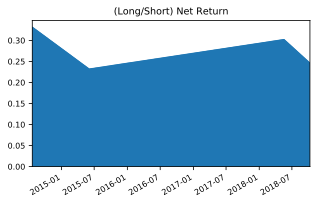

In [960]:
mean_ret['net_exp'].plot.area(title='(Long/Short) Net Return');

In [961]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long'] - 1).mul(l_w) - 
        (mean_ret['short'] - 1).mul(1 - l_w) + 1)
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [962]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
#         monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(((scenarios['mean'] - 1) / scenarios['std']))]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
#     print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
#     monthly_ret.cumprod().plot();

count  mean  std  min  25%  50%  75%  max    l     s
0    4.00  1.24 0.03 1.20 1.22 1.24 1.27 1.28 0.40  0.60
1    4.00  1.26 0.04 1.22 1.23 1.26 1.29 1.31 0.45  0.55
2    4.00  1.28 0.05 1.23 1.24 1.27 1.31 1.33 0.50  0.50
3    4.00  1.29 0.05 1.24 1.25 1.29 1.33 1.36 0.55  0.45
4    4.00  1.31 0.06 1.26 1.26 1.30 1.35 1.38 0.60  0.40
5    4.00  1.33 0.07 1.27 1.27 1.32 1.37 1.41 0.65  0.35
6    4.00  1.34 0.07 1.28 1.28 1.33 1.39 1.43 0.70  0.30
7    4.00  1.36 0.08 1.29 1.30 1.35 1.41 1.46 0.75  0.25
8    4.00  1.38 0.09 1.30 1.31 1.36 1.43 1.48 0.80  0.20
9    4.00  1.40 0.09 1.31 1.32 1.38 1.45 1.51 0.85  0.15
10   4.00  1.41 0.10 1.32 1.33 1.40 1.47 1.53 0.90  0.10
11   4.00  1.43 0.11 1.33 1.35 1.41 1.50 1.56 0.95  0.05
12   4.00  1.45 0.11 1.34 1.36 1.43 1.52 1.58 1.00  0.00
13   4.00  1.46 0.12 1.35 1.37 1.45 1.54 1.61 1.05 -0.05
14   4.00  1.48 0.13 1.36 1.38 1.46 1.56 1.63 1.10 -0.10
15   4.00  1.50 0.13 1.37 1.40 1.48 1.58 1.66 1.15 -0.15

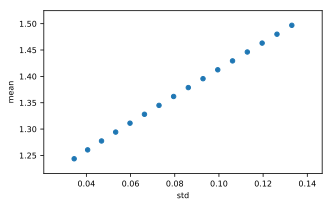

In [963]:
scenarios[['mean', 'std']].plot(kind='scatter', x='std', y='mean')
scenarios